<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regression circle

How can we fit a circle on four or more points?

First let's try the least squares method (LSM) to find a solution.

Unfortunately the equations are not linear, but we can change it to a quadratic equation of a single variable:

${(x - x_0)}^{2} + {(y - y_0)}^{2} = r^2$

We have x and y positions of points on the circle, and we would like to find $x_0, y_0, r$.
Removing the bracket we get:

$x^2 - 2 x x_0 + {x_0}^2 + y^2 -2 y y_0 + {y_0}^2 = r^2$

Let's reorder the tags:

$y^2 + x^2  -2 x_0 x -2 y_0 y + x_0^2 + y_0^2 -r^2 = 0$

Lest substitute the unknowns:

$a_1 = -2 x_0$

$a_2 = -2 y_0$

$a_3 = x_0^2 + y_0^2 - r^2$

$x a_1 + y a_2 + a_3 =  -(x^2 + y^2)$

So we get a linear equation of three unknowns $a_1, a_2, a_3$ for each measured point, 
which is solved applying LSM using numpy.

Finally we can calculate the original unknowns:

$x_0 = 0.5 a_1$

$y_0 = 0.5 a_2$

$r = \sqrt {x_0^2 + y_0^2 - a_3}$

In [30]:
from math import sqrt, pi, sin, cos, sqrt   # used mathematical and triginimetrical functions
import numpy as np                          # matrix operations
import matplotlib.pyplot as plt             # chart plotting

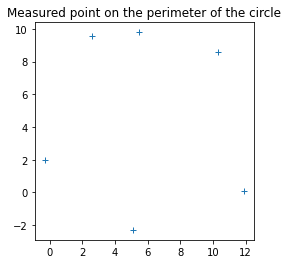

In [31]:
# sample data
x = np.array([ 11.88, 10.34, 2.58, -0.29, 5.1, 5.5])
y = np.array([  0.08,  8.59, 9.54,  1.95, -2.3, 9.8 ])
plt.plot(x, y, '+')
plt.axis('scaled')
_ = plt.title('Measured point on the perimeter of the circle')

Setting up and solving the equation system

\begin{align}
        A = \begin{pmatrix}
            x_1 & y_1 & 1 \\
            x_2 & y_2 & 1 \\
            x_3 & y_3 & 1 \\
            x_4 & y_4 & 1 \\
            x_5 & y_5 & 1 \\
            x_6 & y_6 & 1 
        \end{pmatrix}.
\end{align}

\begin{align}
    b = \begin{pmatrix}
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2 \\
        x_1^2 + y_1^2
    \end{pmatrix}.
\end{align}

Note in the formula above the matrix indices start from 1 while in Python they start from 0.

In [32]:
# coefficients of unknowns
A = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
# pure terms
b = -(x * x + y * y)
# solution for a1, a2, a3
Q = np.linalg.inv(np.matmul(A.T, A))
par = np.matmul(Q, np.matmul(A.T, b))
# calculating the original unknowns
x0 = -0.5 * par[0]
y0 = -0.5 * par[1]
r = sqrt(x0**2 + y0**2 - par[2])
print("The equation of the circle")
print(f"(x - {x0:.3f})^2 + (y - {y0:.3f})^2 = {r:.3f}")

The equation of the circle
(x - 6.128)^2 + (y - 3.729)^2 = 6.495


Accuracy can be described by the residual in each point

$v = \sqrt{{(x - x_0)}^{2} + {(y - y_0)}^{2}} - r$

In [33]:
# residuals
res = np.sqrt((x - x0)**2 + (y - y0)**2) -r
print("residuals:")
print([f"{v:.3f} " for v in res])

residuals:
['0.316 ', '-0.063 ', '0.314 ', '0.165 ', '-0.380 ', '-0.392 ']


and by the root mean square error:

$rms = \sqrt {\frac {\sum{v^2}} {n}}$

In [34]:
#root mean square error
rms = sqrt(np.mean(res**2))
print(f"rms: {rms:.3f}")

rms: 0.296


Let's display points and circle

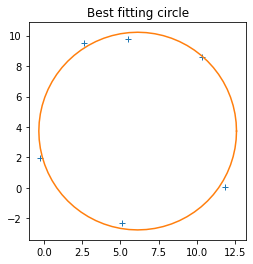

In [35]:

plt.plot(x, y, '+')
plt.plot([x0 + r * cos(alfa / 180 * pi) for alfa in range(0, 361, 5)],
         [y0 + r * sin(alfa / 180 * pi) for alfa in range(0, 361, 5)])
plt.axis('scaled')
_ = plt.title("Best fitting circle")

Let's calculate the estimated accuracy of the unknowns. The weight coefficient matrix of unknowns  is the inverse of normal matrix:
$Q = {N}^{-1}=(A^TA)^{-1}$

The mean error of unit weight (called as proportionality factor, too):

$c^2 = \frac {\sum{v^2}} {(n-3)}$

The variance and covariance matrix

$C=c^2Q$

The standard deviation of unkowns ${a_1, a_2, a_3}$ are in the diagonal of the variance and covariance matrix. Applying the error propagation law, we can get the standard deviation of ${x_0}$ and ${y_0}$:

${m_{x0} = 0.5 * \sqrt{C_{1,1}}}$

${m_{y0} = 0.5 * \sqrt{C_{2,2}}}$


In [37]:
c2 = np.sum(res**2) / (np.size(x)-3)
C = c2 * Q 
mx0 = 0.5 * sqrt(C[0,0]) 
my0 = 0.5 * sqrt(C[1,1]) 
print(Q)
print(f"c2: {c2:.3f}")
print(C)
print(f"mx0: {mx0:.3f} my0: {my0:.3f} ")

[[ 9.49156651e-03  3.91082449e-04 -5.73443735e-02]
 [ 3.91082449e-04  7.03730378e-03 -3.47304546e-02]
 [-5.73443735e-02 -3.47304546e-02  6.62334221e-01]]
c2: 0.176
[[ 1.66693341e-03  6.86829092e-05 -1.00709669e-02]
 [ 6.86829092e-05  1.23590945e-03 -6.09945207e-03]
 [-1.00709669e-02 -6.09945207e-03  1.16320845e-01]]
mx0: 0.020 my0: 0.018 


# Regression sphere

Similar way to circle we can find a regression sphere through four or more points. The equation of the sphere:

$(x - x_0)^2 + (y - y_0)^2 + (z - z_0)^2 = r^2$

Removing the brakets and reordering tags we get:

$y^2 + x^2 + z^2 - 2x_0 x - 2y_0 y -2z_0 z + x_0^2 + y_0^2 + z_0^2 - r^2 = 0$

Let's make supstitution to have linear formula:

$a_1 = -2x_0$

$a_2 = -2y_0$

$a_3 = -2z_0$

$a_4 = x_0^2 + y_0^2 + z_0^2 - r^2$

$y^2 + x^2 + z^2 + a_1 x + a_2 y + a_3 z + a_4 = 0$

We can set up one equation for each point.

Let's write a Python function to solve the equation system using LSM.


In [ ]:
def sphere(x, y, z):
    """ Fit LSM sphere to points
        returns tuple of x0, y0, z0, r
    """
    # coefficients of unknowns
    a = np.stack((x, y, z, np.full(x.size, 1.0)), axis=1)
    # pure term
    b = -(x * x + y * y + z * z)
    # solution for a1, a2, a3, a4
    par = np.linalg.lstsq(a, b, rcond=None)
    x0 = -0.5 * par[0][0]
    y0 = -0.5 * par[0][1]
    z0 = -0.5 * par[0][2]
    r = sqrt(x0**2 + y0**2 + z0**2 - par[0][3])
    return x0, y0, z0, r

Simple test for four points:

In [ ]:
x = np.array([102.167, 102.178, 102.145, 102.135])
y = np.array([99.674, 99.754, 99.752, 99.675])
z = np.array([58.389, 58.383, 58.411, 58.414])
sphere(x, y, z)

(101.98468099701024, 99.72486987889539, 58.18659688074311, 0.277119082985473)

# Robust estimation of parameters using RANSAC

What happens if we have an outlier among the points? If we have few points we can find outlier from a figure or we can use data snooping. Using laser scenners or photogrammetry we get point clouds where there are huge number of points and usually many outliers.

This case Random Sample Consensus (RANSAC) comes into consideration.

In [ ]:
def circle(x, y):
    """ circle through points
        returns tuple of x0, y0, r
    """
    # coefficients of unknowns
    a = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
    # pure term
    b = -(x * x + y * y)
    # solution for a1, a2, a3
    par = np.linalg.lstsq(a, b, rcond=None)
    x0 = -0.5 * par[0][0]
    y0 = -0.5 * par[0][1]
    r = sqrt(x0**2 + y0**2 - par[0][2])
    return x0, y0, r

Text the function

In [ ]:
# circle throug three points
circle(x[0:3], y[0:3])

(5.762471327735672, 3.367292108661916, 6.944814357752633)

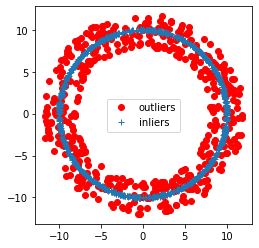

In [ ]:
# generating test data
from random import random, seed, randint
seed()
# random points on circle
n = 1000    # number of points on the circle
m = 500     # number of outlier points 
r_range = 0.2
r_base = 10.0
x = np.zeros(n+m)
y = np.zeros(n+m)
for i in range(n):
    alpha = random() * pi * 2   # angle between 0-360 degre in radians
    r = r_base + (random() - 0.5) * r_range   # random radius
    x[i] = r * sin(alpha)
    y[i] = r * cos(alpha)
for i in range(n, n+m):
    alpha = random() * pi * 2   # angle between 0-360 degre in radians
    r = r_base + (random() - 0.5) * 20 * r_range
    x[i] = r * sin(alpha)
    y[i] = r * cos(alpha)
plt.plot(x[n:n+m], y[n:n+m], 'ro', label="outliers")
plt.plot(x[:n], y[:n], '+', label="inliers")
plt.legend()
_ = plt.axis('scaled')

Fit circle to randomly selected three points several times and choose the one which is close to the most points.

In [ ]:
# RANSAC
n_try = n // 3
best = 0
print("centerx centery radius    fit   iter")
for i in range(n_try):
    index = [randint(0, n+m-1) for i in range(3)]    # three random index
    x3 = x[index]   # three random points
    y3 = y[index]
    xc, yc, r3 = circle(x3, y3)
    # distance from the circle
    dist = np.absolute(np.sqrt((x - xc)**2 + (y - yc)**2) - r3)
    n_fit = dist[dist < r_range/2].size
    #print(index, i, n_fit)
    if n_fit > best:
        best = n_fit
        best_xc = xc
        best_yc = yc
        best_r = r3
        print(f"{best_xc:6.3f}, {best_yc:6.3f}, {best_r:6.3f}, {best:5d}, {i:5d}")

centerx centery radius    fit   iter
-0.032,  0.111, 10.081,   565,     0
 0.042, -0.033,  9.973,   864,     1
 0.014, -0.029,  9.995,   923,    23
 0.027,  0.016, 10.003,   938,    51
 0.030,  0.007,  9.993,   941,   312


941


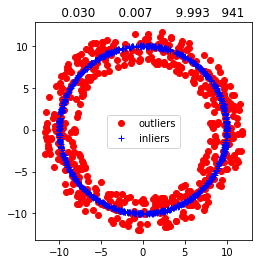

In [ ]:
# plot result
plt.title(f"{best_xc:10.3f} {best_yc:10.3f} {best_r:10.3f} {best:5d}")
plt.plot([best_xc + best_r * sin(alfa / 180 * pi) for alfa in range(0, 361)],
         [best_yc + best_r * cos(alfa / 180 * pi) for alfa in range(0, 361)])
dist = np.absolute(np.sqrt((x - best_xc)**2 + (y - best_yc)**2) - best_r)
print(x[dist < r_range/2].size)
plt.plot(x[dist > r_range/2], y[dist > r_range/2], "ro", label='outliers')
plt.plot(x[dist < r_range/2], y[dist < r_range/2], "b+", label="inliers")
plt.axis('scaled')
_ = plt.legend()

Finaly, let's fit LMS circle to the inliers.

In [ ]:
xc_final, yc_final, r_final = circle(x[dist < r_range/2], y[dist < r_range/2])
print(f"{xc_final:6.3f}, {yc_final:6.3f}, {r_final:6.3f}")

 0.020,  0.001,  9.997
